In [2]:
#importa as bibliotecas necessarias
library(plyr)
library(dplyr)
library(sqldf)
library(plotrix)
library(ggplot2)
library(treemap)
library(fpCompare)
library(rpart)
library(partykit)
library(stringr)
library(zoo)
library(lubridate)
library(tree)
library(bnlearn)
library(readr)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'sqldf' was built under R version 3.4.1"Loading required package: gsubfn
Warning message:
"package 'gsubfn' was built under R version 3.4.1"Loading required package: proto
Warning message:
"package 'proto' was built under R version 3.4.1"Loading required package: RSQLite
Warning message:
"package 'RSQLite' was built under R version 3.4.1"Warning message:
"package 'treemap' was built under R version 3.4.1"Warning message:
"package 'fpCompare' was built under R version 3.4.1"Warning message:
"package 'rpart' was built under R version 3.4.1"Warning message:
"package 'partykit' was built under R version 3.4.1"Loading required package: 

In [3]:
load(".RData")


In [4]:
#Cria as funcoes de preprocessamento

realizar_preprocessamento <- function(aihs, remover_obst = TRUE, remover_nao_csap = TRUE) {
  aihs <- subset(aihs, IDENT == 1)
  #Alimenta o dataset com os grupos mais genericos de CID 
  aihs$GRUPO_CID_PRINC = substr(aihs$DIAG_PRINC, 1, 3)
  
  aihs$GRUPO_CSAP <- sapply(aihs$DIAG_PRINC, classificar_grupo_csap)
  aihs$CSAP <- sapply(aihs$GRUPO_CSAP, is_csap)
  if(remover_nao_csap == T) {
    aihs <- subset(aihs, CSAP == T)
  }
  
  aihs <- trata_campos(aihs)
  aihs <- remove_campos_desnecessarios(aihs)
  if(remover_obst == T) {
    aihs <- remover_procedimentos_obstetricos(aihs)
  }
  
  #remove a coluna UF ZI e deixa apenas o codigo da UF do ibge
  aihs$UF <- substr(aihs$UF_ZI, 1, 2)
  aihs$UF_ZI <- NULL
  
  
  return(aihs)
}

trata_campos <- function(aihs) {
	#Alimenta o dataset com os grupos mais genericos de CID 
	aihs$GRUPO_CID_PRINC = substr(aihs$DIAG_PRINC, 1, 3)

	#CORRIGE INCONSISTENCIA NAS IDADES. CONVERTE A DATA DE NASCIMENTO E DATA DA INTERNACAO PARA FORMATO DE DATAS
	aihs$DT_INTER = str_replace_all(paste(substr(aihs$DT_INTER, 5, 6), "/", substr(aihs$DT_INTER, 7, 8), "/", substr(aihs$DT_INTER, 1, 4)), ' ', '')
	aihs$DT_INTER =as.Date(aihs$DT_INTER, "%m/%d/%Y")


	aihs$DT_SAIDA = str_replace_all(paste(substr(aihs$DT_SAIDA, 5, 6), "/", substr(aihs$DT_SAIDA, 7, 8), "/", substr(aihs$DT_SAIDA, 1, 4)), ' ', '')
	aihs$DT_SAIDA =as.Date(aihs$DT_SAIDA, "%m/%d/%Y")

	aihs$NASC = str_replace_all(paste(substr(aihs$NASC, 5, 6), "/", substr(aihs$NASC, 7, 8), "/", substr(aihs$NASC, 1, 4)), ' ', '')
	aihs$NASC =as.Date(aihs$NASC, "%m/%d/%Y")

	#Funcao para calcular idade
	age <- function(dob, age.day = today(), units = "years", floor = TRUE) {
	  calc.age = interval(dob, age.day) / duration(num = 1, units = units)
	  if (floor) return(as.integer(floor(calc.age)))
	  return(calc.age)
	}
	#Corrige a idade dos pacientes com base na data de internacao e data de nascimento
	aihs$IDADE = age(aihs$NASC, age.day = aihs$DT_INTER)
	#Ja que possui idade, nao precisa de data de nascimento nem do COD_IDADE
	aihs$NASC <- NULL
	aihs$COD_IDADE <- NULL
	
	#Alimenta a Faixa Etaria baseada na idade. Campo COD_IDADE apresentava inconsistencias
	#Funcao para definir faixa etaria :
	#----------------------------------------------
	# 0 a 1 ano : BEBE -- BEBE
	# 2 a 5 anos: CRIANCA_1 -  Crianca Faixa 1
	# 6 a 11 anos: CRIANCA_2 - Crianca Faixa 2
	# 12 a 17 anos: ADOLESCENTE - Adolescente
	# 18 a 30 anos: ADULTO_JOVEM - Adulto Jovem
	# 31 a 59 anos: ADULTO_MADURO - Adulto Maduro
	# 60 a 74 anos: IDOSO_1 - Idoso Faixa 1
	# 75 a 90 anos: IDOSO_2 - Idoso Faixa 2
	# Maior ou igual a 91 anos: IDOSO_3 - Idoso Faixa 3
	#----------------------------------------------
	func_faixa_etaria <- function(idade) {
	  if(idade %==% 0 || idade %==% 1) {
		return ("BEBE")
	  } else if(idade %>=% 2 && idade %<=% 5) {
		return ("CRIANCA_1")
	  } else if(idade %>=% 6 && idade %<=% 11) {
		return ("CRIANCA_2")
	  } else if(idade %>=% 12 && idade %<=% 17) {
		return ("ADOLESCENTE")
	  } else if(idade %>=% 18 && idade %<=% 30) {
		return ("ADULTO_JOVEM")
	  } else if(idade %>=% 31 && idade %<=% 59) {
		return ("ADULTO_MADURO")
	  } else if(idade %>=% 60 && idade %<=% 74) {
		return ("IDOSO_1")
	  } else if(idade %>=% 75 && idade %<=% 90) {
		return ("IDOSO_2")
	  } else if(idade %>=% 91) {
		return ("IDOSO_3")
	  }
	}

	faixa_etaria = sapply(aihs$IDADE, func_faixa_etaria)
	aihs$FAIXA_ETARIA <- faixa_etaria
	
	#------------------------------------------------------------
	# Converte os campos necessarios em factors
	#------------------------------------------------------------
	aihs$GRUPO_CID_PRINC <- as.factor(aihs$GRUPO_CID_PRINC)
	aihs$SEXO <- as.factor(aihs$SEXO)
	aihs$MORTE <- as.factor(aihs$MORTE)
	
	
	return(aihs)
}



# Cria uma funcao para limpar colunas que tenham muitos valores NA, com variancia muito baixa ou com todos os valores repetidos
remove_campos_desnecessarios <- function(dados) {
  #Realizar limpeza dos dados
  library(fpCompare)
  tol = .Machine$double.eps^0.5       # default value
  options(fpCompare.tolerance = tol)
  
  num_colunas <- length(colnames(dados))
  total_observacoes = length(dados[,1])
  i = 1
  #faz o loop nas colunas para verificar se possuem dados que podem ser excluidos
  while(i <= num_colunas) {
    numero_na = sum(is.na(dados[,i]))
    proporcao_na = numero_na / total_observacoes
    proporcao_na = round(proporcao_na, 2)
    motivos_exclusao = 0
    comp = .20
    excluido = F
    if(proporcao_na %>=% comp) {
	  print(paste('Removendo a coluna porque tem grande proporcao de valores nulos: ', colnames(dados)[i]))
      dados[,i] <- NULL
      excluido <- T
    }
    
    #verifica a variancia
    comp = 1
    
    if(excluido == F) {
	  if(is.numeric(dados[,i])) {
		  variancia = var(dados[,i], na.rm = TRUE)
		  variancia = round(variancia, 2)
		  comp = 0
		  if(!is.na(variancia) && isTRUE(all.equal(variancia, comp, tolerance = .Machine$double.eps ^ 0.05))) {
			print(paste('Removendo a coluna por variancia proxima a ZERO: ', colnames(dados)[i], "VAR: ", variancia))
			dados[,i] = NULL
			excluido = T
		  } else if(is.na(variancia)) {
			print(paste('Removendo a coluna por variancia NA: ', colnames(dados)[i]))
			dados[,i] = NULL
			excluido = T
		  }
	  }
    }
	
	# Verifica se o campo possui todos os valores repetidos. 
	# Caso tenha, o tamanho do item retornado na funcao table sera 1
	
	if(excluido == F) {
		if(is.character(dados[,i])) {
			temp = unique(dados[,i])
		  #library(sqldf)
			#temp = sqldf(paste("select ", colnames(dados)[i], ", count(*) num from dados "))
			if(length(temp) == 1) {
				print(paste('Removendo a coluna por Todos os dados serem iguais: ', colnames(dados)[i]))
				dados[,i] = NULL
				excluido = T
			}
		}
	}
	
    if(excluido == T) {
      num_colunas <- length(colnames(dados))
    } else {
      i = i + 1
    }
    
  }
  return(dados)
}


#Funcao para obter apenas os grupos CSAP
classificar_grupo_csap <- function(cid) {
  
  #----------------------------------------------------------------------------
  #  LISTA BRASILEIRA DE INTERNACOES POR CONDICOES SENSIVEIS A ATENCAO PRIMARIA
  #                                  CSAP
  #               Portaria MS nº 221, de 17 de abril de 2008
  #----------------------------------------------------------------------------
  #
  # GRUPO 01 - Doencas preveníveis por imunizacoes e condicoes sensiveis
  grupo <- -1
  cids <- list(
			c("A33", "A34", "A35", "G000"),
			c("E86", "A09"),
			c(),
			c("E44","E46", "E52", "E54", "E58", "E59", "E60"),
			c("J00"),
			c("J13", "J14", "J153", "J154", "J158", "J159", "J181"),
			c("J46"),
			c("J40", "J42", "J47"),
			c("I10"),
			c(),
			c("J81"),
			c("I64"),
			c("E100", "E101", "E110", "E111", "E120", "E121", "E130", "E131", "E140", "E141",
					"E102", "E103", "E104", "E105", "E106", "E107", "E108",
					"E112", "E113", "E114", "E115", "E116", "E117", "E118",
					"E122", "E123", "E124", "E125", "E126", "E127", "E128",
					"E132", "E133", "E134", "E135", "E136", "E137", "E138",
					"E142", "E143", "E144", "E145", "E146", "E147", "E148",
					"E109", "E119", "E129", "E139", "E149"),
			c(),
			c("N10", "N12", "N390"),
			c("A46"),
			c("N72"),
			c("K920", "K921", "K922"),
			c("P350")
		  )
				
   grupos <- list( c("A37", "A36", "B26", "B06", "B05", "A95", "B16", "A19", "A15", "A16", "A17", "A18", "I00", "I01", "I02", 
					"A51", "A52", "A53", "B50", "B51", "B52", "B53", "B54", "B77"),
				c("A00", "A01", "A02", "A03", "A04", "A05", "A06", "A07", "A08"),
				c("D50"),
				c("E40", "E41", "E42", "E43","E45", "E50", "E51", "E53", "E55", "E56", "E61", "E63", "E64"),
				c("H66", "J01", "J02", "J03", "J06", "J31"),
				c(),
				c("J45"),
				c("J20", "J21", "J41", "J43", "J44"),
				c("I11"),
				c("I20"),
				c("I50"),
				c("I63", "I65", "I66", "I67", "I69", "G45", "G46"),
				c(),
				c("G40", "G41"),
				c("N11", "N30", "N34"),
				c("L01", "L02", "L03", "L04", "L08"),
				c("N70", "N71", "N73", "N75", "N76"),
				c("K25", "K26", "K27", "K28"),
				c("O23", "A50")
			)
  for(i in 1:length(cids)) {
	if(substr(cid, 1,3) %in% grupos[[i]] || cid %in% cids[[i]]) {
		grupo <- i
		break
	}
  }
  return (grupo)
}


is_csap <- function(grupo) {
	csap = F
	if(grupo > -1) {
		csap = T
	}
	return(csap)
}


remover_procedimentos_obstetricos <- function(aihs) {
	procedimentos <- c('0310010012', '0310010020', '0310010039', '0310010047', '0411010018', '0411010026', 
                      '0411010034', '0411010042', '0411020013', '0411020021')
	aihs <- subset(aihs, !(PROC_REA %in% procedimentos))
	aihs <- subset(aihs, !(PROC_SOLIC %in% procedimentos))
	return(aihs)
}


In [5]:
#Realiza o pré-processamento
dados_preprocessados = realizar_preprocessamento(consolidacao, remover_nao_csap=F, remover_obst = F)

[1] "Removendo a coluna porque tem grande proporcao de valores nulos:  CGC_HOSP"
[1] "Removendo a coluna por Todos os dados serem iguais:  IDENT"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_MES_IN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_MES_AN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_MES_AL VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_INT_IN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_INT_AN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_INT_AL VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_SADT VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_RN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_ACOMP VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_ORTP VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_SANGUE VAR:  0"
[1] "Removendo a coluna por variancia 

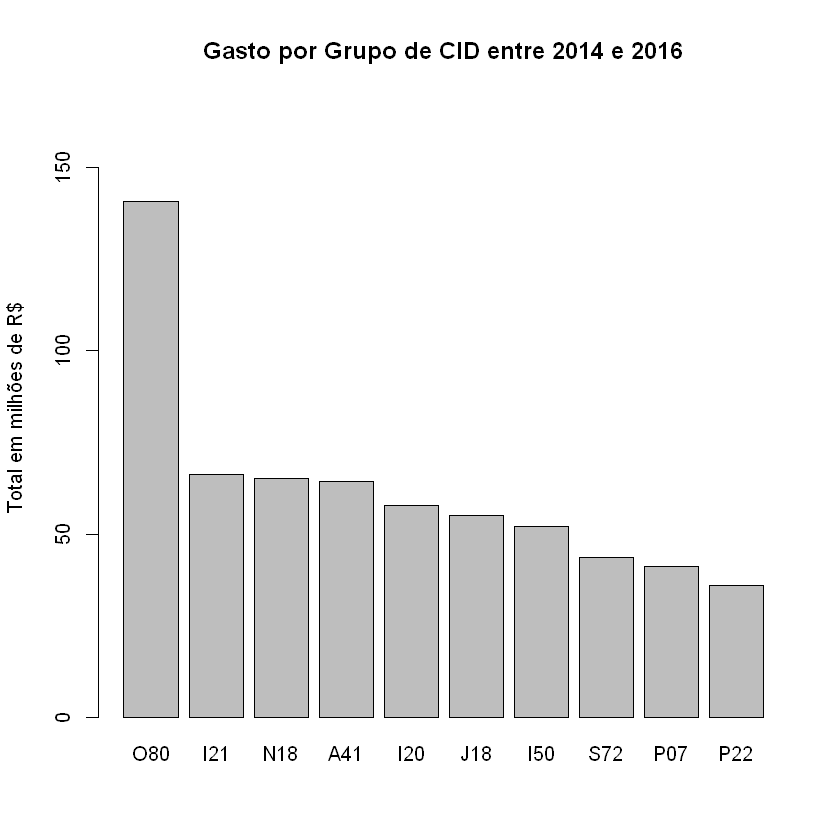

In [6]:


# -----------------------------------------------------------------------------------------------
# Faz a Análise de Dados
# -----------------------------------------------------------------------------------------------

#Verifica o gasto de internacoes por esses grupos
gasto_por_grupo_cid = aggregate(dados_preprocessados$VAL_TOT, by=list(Category=dados_preprocessados$GRUPO_CID_PRINC), FUN=sum)
gasto_por_grupo_cid_desc = arrange(gasto_por_grupo_cid, desc(x))

limite_plot_gasto_grupo = max(gasto_por_grupo_cid_desc$x) / 10^6 * 1.2

barplot(gasto_por_grupo_cid_desc$x[1:10] / 10^6,  names.arg = gasto_por_grupo_cid_desc$Category[1:10], 
        main="Gasto por Grupo de CID entre 2014 e 2016", ylab="Total em milhões de R$", ylim = c(0, limite_plot_gasto_grupo))

[1] 1953240

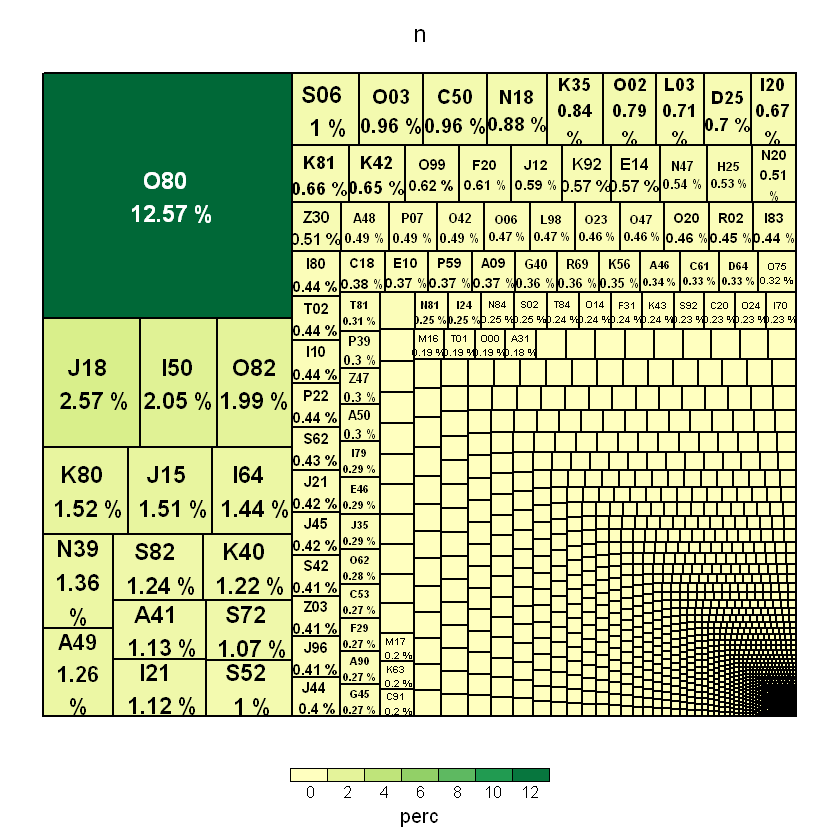

In [7]:
#Conta o numero de internacoes por GRUPO
internacoes_por_grupo = count(dados_preprocessados, GRUPO_CID_PRINC)
internacoes_por_grupo_desc = arrange(internacoes_por_grupo, desc(n))


total_internacoes = nrow(dados_preprocessados)
total_internacoes
#Prepara o modelo para plotar com a porcentagem
modelo_internacoes_por_grupo = internacoes_por_grupo_desc
modelo_internacoes_por_grupo$perc = round(modelo_internacoes_por_grupo$n / total_internacoes * 100, 2)
modelo_internacoes_por_grupo$label = paste(modelo_internacoes_por_grupo$GRUPO_CID_PRINC, '\n', modelo_internacoes_por_grupo$perc, '%')

#Plota a proporção
treemap(modelo_internacoes_por_grupo, index="label", vSize="n", vColor="perc", type="value", fontsize.title = 14, fontsize.labels = 14) 


Attaching package: 'scales'

The following object is masked from 'package:readr':

    col_factor

The following object is masked from 'package:plotrix':

    rescale



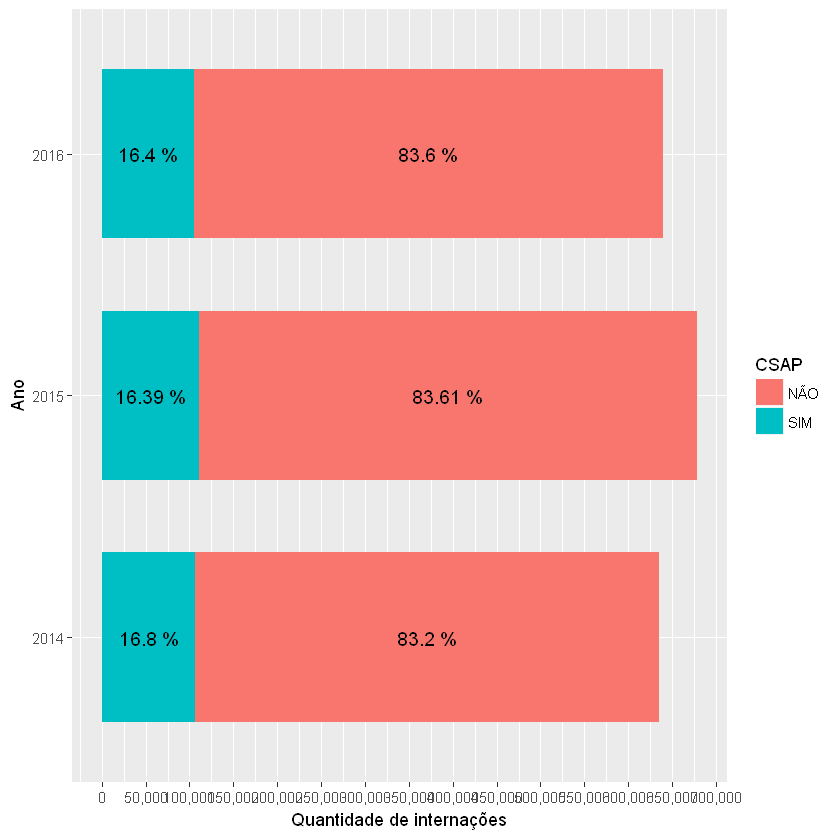

In [8]:


#Cria um grafico por ano de proporcao de internacoes csap e aih
proporcao_internacao_csap = sqldf("select count(*) num, tot, CSAP, ANO_CMPT from dados_preprocessados, 
                                  (select count(*) tot, ANO_CMPT AS ANO  from dados_preprocessados GROUP BY ANO_CMPT) AS TOTAL
                                  WHERE TOTAL.ANO = dados_preprocessados.ANO_CMPT
                                  GROUP BY CSAP, ANO_CMPT, tot 
                                  ORDER BY ANO_CMPT")
#calcula o percentual
proporcao_internacao_csap$perc = round(proporcao_internacao_csap$num / proporcao_internacao_csap$tot * 100, 2)
proporcao_internacao_csap$csap_chr = ifelse(proporcao_internacao_csap$CSAP == T, 'SIM', 'NÃO')


library(scales)

ggplot(proporcao_internacao_csap, aes(x=ANO_CMPT, y=num, fill=csap_chr)) + 
  geom_bar(position = position_stack(), stat = "identity", width = .7) +
  geom_text(aes(label = paste(perc, '%')), position = position_stack(vjust = 0.5), size = 4) +
  coord_flip() +
  xlab("Ano") +
  ylab("Quantidade de internações") +
  guides(fill=guide_legend(title="CSAP")) +
  scale_y_continuous(labels = scales::comma, breaks = seq(0, max(proporcao_internacao_csap$num) * 1.5, by = 50000))




In [9]:
#-----------------------------------------------------------------------------
# Faz o filtro para realizar o mesmo tipo de analise voltada apenas a CSAP
#-----------------------------------------------------------------------------

dados_preprocessados = realizar_preprocessamento(consolidacao, remover_obst = F)

[1] "Removendo a coluna porque tem grande proporcao de valores nulos:  CGC_HOSP"
[1] "Removendo a coluna por Todos os dados serem iguais:  IDENT"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_MES_IN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_MES_AN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_MES_AL VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_INT_IN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_INT_AN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_INT_AL VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  UTI_INT_TO VAR:  0.12"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_SADT VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_RN VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_ACOMP VAR:  0"
[1] "Removendo a coluna por variancia proxima a ZERO:  VAL_ORTP VAR:  0"
[1] "Removendo a coluna por varianc

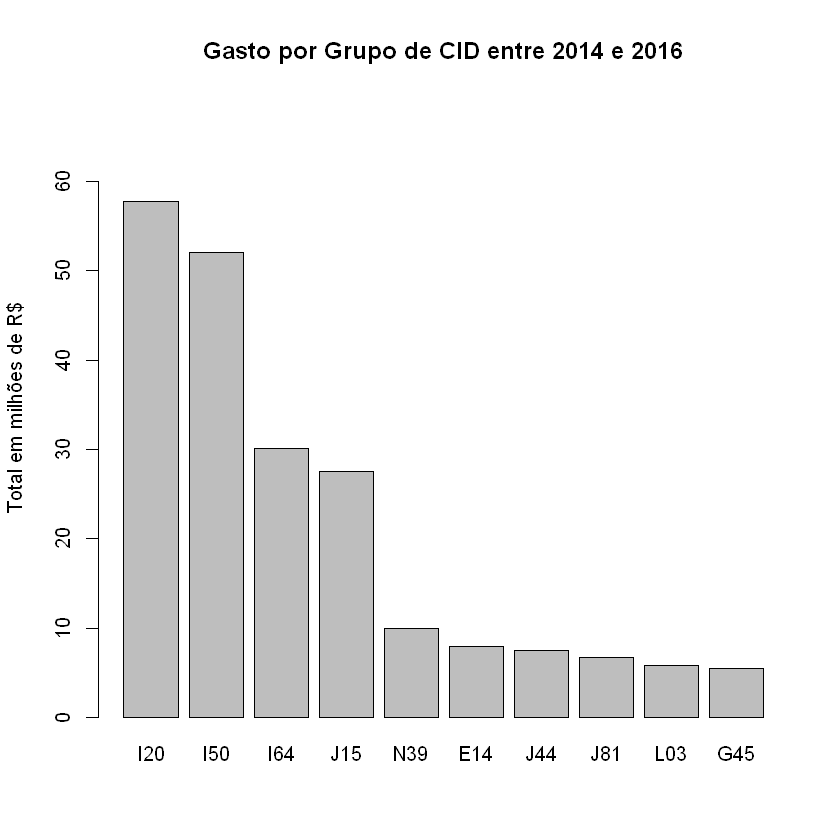

In [10]:
#Verifica o gasto de internacoes por esses grupos
gasto_por_grupo_cid = aggregate(dados_preprocessados$VAL_TOT, by=list(Category=dados_preprocessados$GRUPO_CID_PRINC), FUN=sum)
gasto_por_grupo_cid_desc = arrange(gasto_por_grupo_cid, desc(x))

limite_plot_gasto_grupo = max(gasto_por_grupo_cid_desc$x) / 10^6 * 1.2

barplot(gasto_por_grupo_cid_desc$x[1:10] / 10^6,  names.arg = gasto_por_grupo_cid_desc$Category[1:10], 
        main="Gasto por Grupo de CID entre 2014 e 2016", ylab="Total em milhões de R$", ylim = c(0, limite_plot_gasto_grupo))

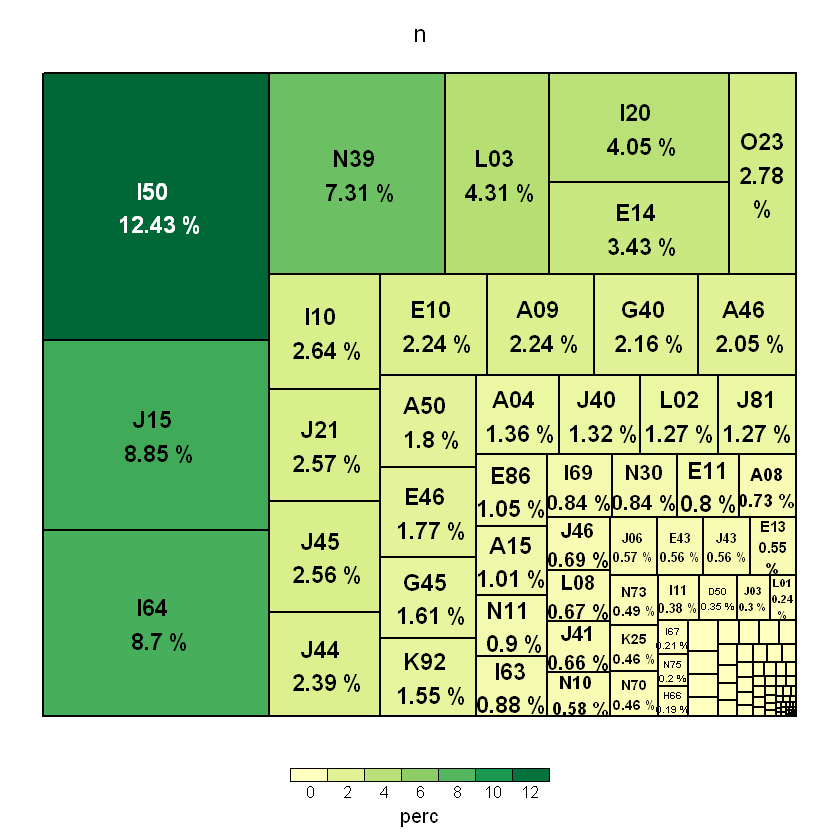

In [11]:
#Conta o numero de internacoes por GRUPO
internacoes_por_grupo = count(dados_preprocessados, GRUPO_CID_PRINC)
internacoes_por_grupo_desc = arrange(internacoes_por_grupo, desc(n))

total_internacoes = nrow(dados_preprocessados)
#Prepara o modelo para plotar com a porcentagem
modelo_internacoes_por_grupo = internacoes_por_grupo_desc
modelo_internacoes_por_grupo$perc = round(modelo_internacoes_por_grupo$n / total_internacoes * 100, 2)
modelo_internacoes_por_grupo$label = paste(modelo_internacoes_por_grupo$GRUPO_CID_PRINC, '\n', modelo_internacoes_por_grupo$perc, '%')

#Plota a proporção
treemap(modelo_internacoes_por_grupo, index="label", vSize="n", vColor="perc", type="value", fontsize.title = 14, fontsize.labels = 14) 

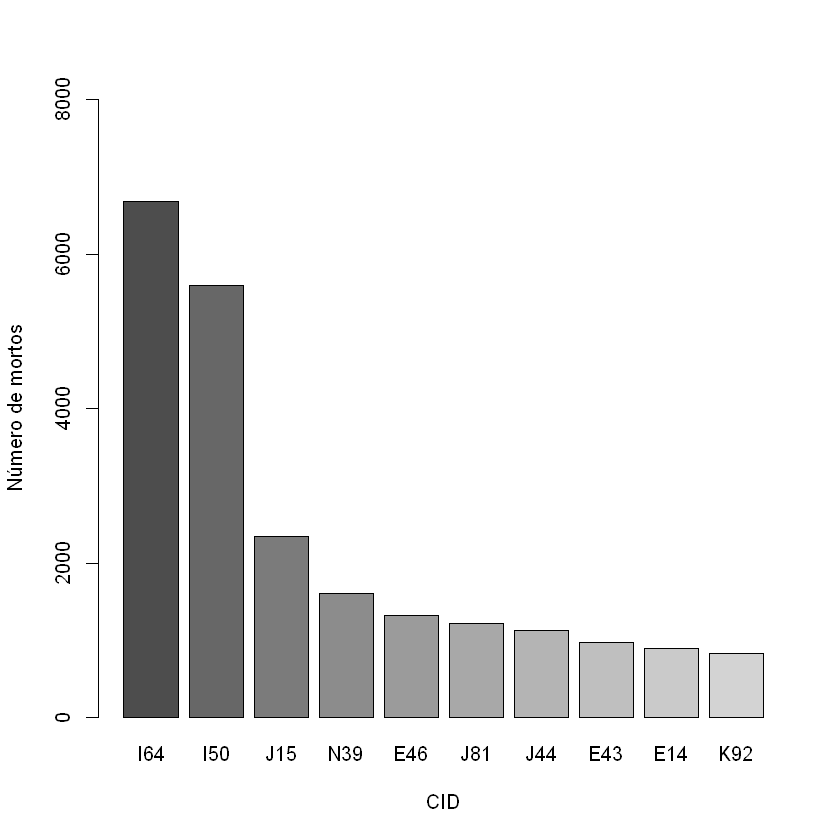

In [12]:
# 
# ---------------------------------------------------
#   MORTALIDADE
# ---------------------------------------------------
# 

mortalidade = subset(dados_preprocessados, MORTE == 1)
mortalidade_grp_cid = sqldf("select GRUPO_CID_PRINC, count(*) n from mortalidade group by GRUPO_CID_PRINC ORDER BY n desc")


#Outras mortalidades
mortalidade_grp_cid_maiores = head(mortalidade_grp_cid, 10)

#Numero de mortos
total_mortes = sum(mortalidade_grp_cid$n)

barplot(mortalidade_grp_cid_maiores$n, names.arg = mortalidade_grp_cid_maiores$GRUPO_CID_PRINC,  col=gray.colors(12),
        ylim = c(0,max(mortalidade_grp_cid_maiores$n) * 1.2), ylab = "Número de mortos", xlab = "CID")


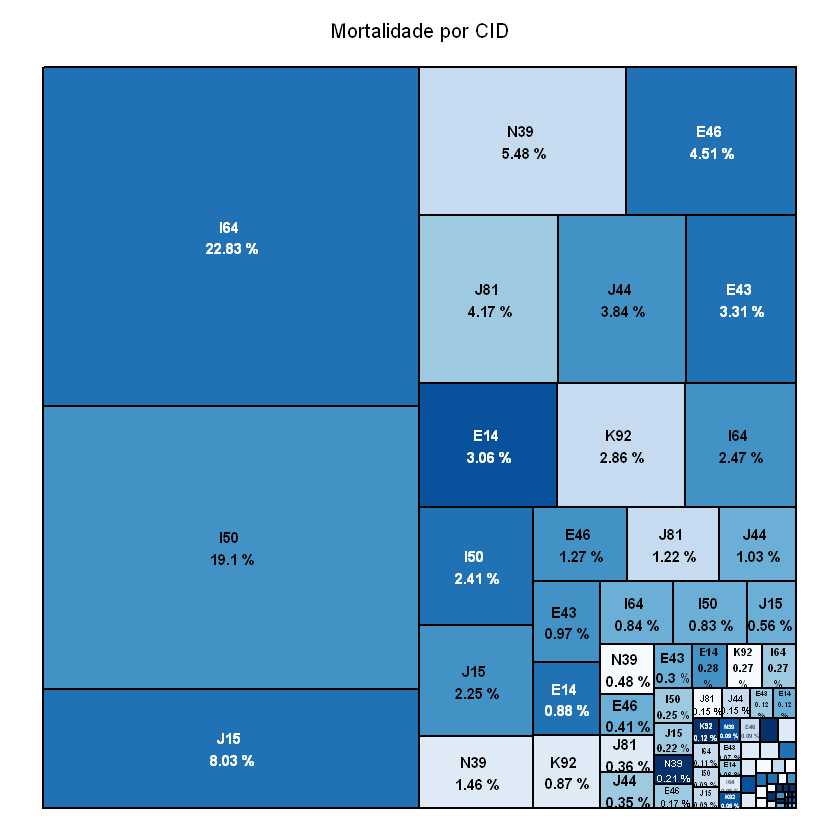

In [13]:

#treemap com percentual -- primeiro estima o resto da area das outras doencas
mortalidade_grp_cid$percentual = mortalidade_grp_cid$n / total_mortes * 100

#cria uma coluna com a porcentagem e o cid
mortalidade_grp_cid$grupo_perc = paste(mortalidade_grp_cid_maiores$GRUPO_CID_PRINC, "\n", round(mortalidade_grp_cid$percentual, 2), "%")

treemap(mortalidade_grp_cid, #Your data frame object
        index=c("grupo_perc"),  #A list of your categorical variables
        vSize = "percentual",  #This is your quantitative variable
        type="index", #Type sets the organization and color scheme of your treemap
        palette = "Blues",  #Select your color palette from the RColorBrewer presets or make your own.
        title="Mortalidade por CID", #Customize your title
        fontsize.title = 12, #Change the font size of the title,
        fontsize.labels = 9
)


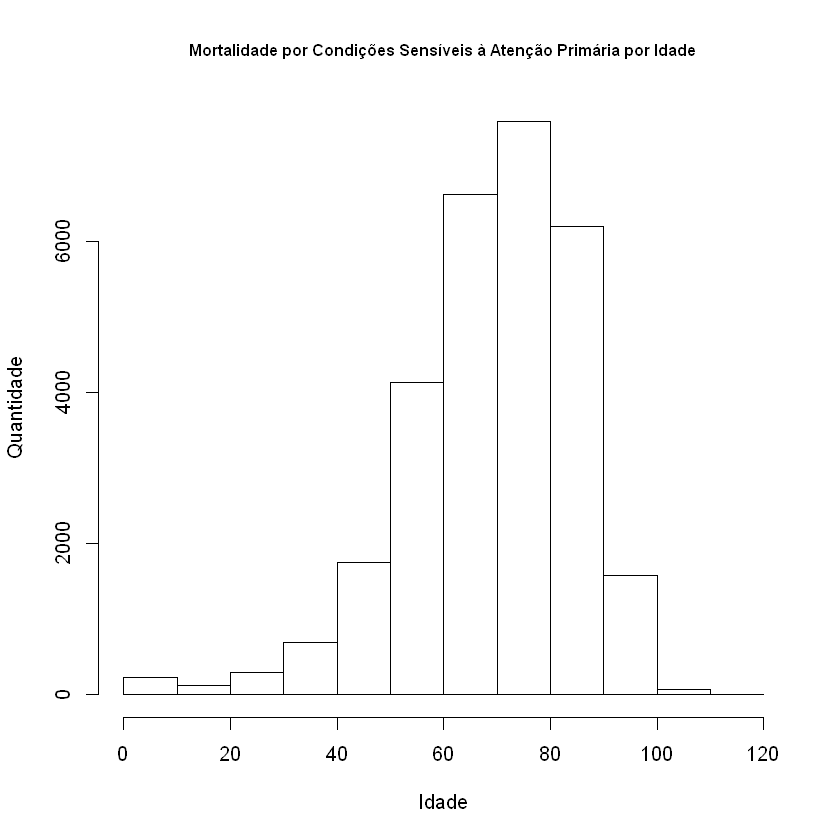

In [14]:
hist(mortalidade$IDADE, main="Mortalidade por Condições Sensíveis à Atenção Primária por Idade", cex.main= .8, ylab="Quantidade", xlab="Idade")

In [15]:
#-------------------------------------------------------------------------------------------------------------
# Usa o classificador Naive-Bayes
#-------------------------------------------------------------------------------------------------------------
#SEPARA OS ATRIBUTOS NECESSARIOS PARA TREINAMENTO
options(max.print = 999999999)
# train the model
dados_attr_necessarios <- data.frame( 
  FAIXA_ETARIA = dados_preprocessados$FAIXA_ETARIA,
  SEXO = dados_preprocessados$SEXO,
  GRUPO_CID_PRINC = dados_preprocessados$GRUPO_CID_PRINC,
  MORTE = dados_preprocessados$MORTE == 1
)

dados_attr_necessarios$MORTE = factor(dados_attr_necessarios$MORTE, levels= c("TRUE", "FALSE"),ordered=TRUE)
rotulos = dados_attr_necessarios$MORTE
dados_attr_necessarios$MORTE <- NULL



In [16]:
#Configura o SEED para treinamento e carrega as bibliotecas do Naive Bayes

set.seed(666)

library(caret)
library(klaR)
library(e1071)


Warning message:
"package 'caret' was built under R version 3.4.1"Loading required package: lattice
Warning message:
"package 'klaR' was built under R version 3.4.1"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Warning message:
"package 'e1071' was built under R version 3.4.1"
Attaching package: 'e1071'

The following object is masked from 'package:bnlearn':

    impute



In [17]:
#---------
# k-fold de validacao cruzada
#---------


#---------
# k = 5
#---------
train_control <- trainControl(method="cv", number=5, savePredictions = T)

model5 <- train(x=dados_attr_necessarios, y=rotulos, trControl=train_control, method="nb")
# summarize results
print(model5)
confusionMatrix(model5)

Naive Bayes 

322795 samples
     3 predictor
     2 classes: 'TRUE', 'FALSE' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 258236, 258236, 258236, 258236, 258236 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa     
  FALSE      0.9082452  0.08642496
   TRUE      0.9082452  0.08642496

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = FALSE and adjust
 = 1.


Cross-Validated (5 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction TRUE FALSE
     TRUE   0.5   0.6
     FALSE  8.5  90.3
                            
 Accuracy (average) : 0.9082


In [18]:

#---------
# k = 10
#---------

train_control <- trainControl(method="cv", number=10, savePredictions = T)

model10 <- train(x=dados_attr_necessarios, y=rotulos, trControl=train_control, method="nb")
# summarize results
print(model10)
confusionMatrix(model10)

Naive Bayes 

322795 samples
     3 predictor
     2 classes: 'TRUE', 'FALSE' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 290516, 290516, 290515, 290516, 290515, 290516, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa     
  FALSE      0.9083536  0.08503625
   TRUE      0.9083536  0.08503625

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = FALSE and adjust
 = 1.


Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction TRUE FALSE
     TRUE   0.5   0.6
     FALSE  8.5  90.3
                            
 Accuracy (average) : 0.9084


In [19]:
#---------
# k = 15
#---------


train_control <- trainControl(method="cv", number=15, savePredictions = T)

model15 <- train(x=dados_attr_necessarios, y=rotulos, trControl=train_control, method="nb")
# summarize results
print(model15)
#predict(model$finalModel, dados_attr_necessarios)
confusionMatrix(model15)

Naive Bayes 

322795 samples
     3 predictor
     2 classes: 'TRUE', 'FALSE' 

No pre-processing
Resampling: Cross-Validated (15 fold) 
Summary of sample sizes: 301276, 301276, 301275, 301276, 301275, 301275, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa     
  FALSE      0.9083722  0.08441033
   TRUE      0.9083722  0.08441033

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = FALSE and adjust
 = 1.


Cross-Validated (15 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction TRUE FALSE
     TRUE   0.5   0.6
     FALSE  8.5  90.3
                            
 Accuracy (average) : 0.9084


In [20]:
#---------
# k = 20
#---------

train_control <- trainControl(method="cv", number=20, savePredictions = T)

model20 <- train(x=dados_attr_necessarios, y=rotulos, trControl=train_control, method="nb")
# summarize results
print(model20)
confusionMatrix(model20)

Naive Bayes 

322795 samples
     3 predictor
     2 classes: 'TRUE', 'FALSE' 

No pre-processing
Resampling: Cross-Validated (20 fold) 
Summary of sample sizes: 306655, 306656, 306655, 306656, 306656, 306654, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa     
  FALSE      0.9083846  0.08453927
   TRUE      0.9083846  0.08453927

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = FALSE and adjust
 = 1.


Cross-Validated (20 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction TRUE FALSE
     TRUE   0.5   0.6
     FALSE  8.5  90.3
                            
 Accuracy (average) : 0.9084


In [21]:
#---------
# k = 100
#---------

train_control <- trainControl(method="cv", number=100, savePredictions = T)

model100 <- train(x=dados_attr_necessarios, y=rotulos, trControl=train_control, method="nb")
# summarize results
print(model100)
confusionMatrix(model100)

Naive Bayes 

322795 samples
     3 predictor
     2 classes: 'TRUE', 'FALSE' 

No pre-processing
Resampling: Cross-Validated (100 fold) 
Summary of sample sizes: 319567, 319566, 319567, 319567, 319566, 319566, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa     
  FALSE      0.9084589  0.08380732
   TRUE      0.9084589  0.08380732

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = FALSE and adjust
 = 1.


Cross-Validated (100 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction TRUE FALSE
     TRUE   0.5   0.6
     FALSE  8.5  90.3
                            
 Accuracy (average) : 0.9085


In [22]:
#Escolhe k=10 e faz a predicao do modelo
resultados10 = predict(model10$finalModel, dados_attr_necessarios)
confusionMatrix(rotulos,resultados10$class)

Confusion Matrix and Statistics

          Reference
Prediction   TRUE  FALSE
     TRUE    1679  27592
     FALSE   1958 291566
                                          
               Accuracy : 0.9085          
                 95% CI : (0.9075, 0.9094)
    No Information Rate : 0.9887          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0837          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.461644        
            Specificity : 0.913548        
         Pos Pred Value : 0.057361        
         Neg Pred Value : 0.993329        
             Prevalence : 0.011267        
         Detection Rate : 0.005201        
   Detection Prevalence : 0.090680        
      Balanced Accuracy : 0.687596        
                                          
       'Positive' Class : TRUE            
                                          